HRCR Definition:

The category addresses management of the relationship between businesses and the
communities in which they operate, including management of direct and indirect impacts on
core human rights and the treatment of indigenous peoples. More specifically, such
management might cover socio-economic community impacts, community engagement,
environmental justice, cultivation of local workforces, impact on local businesses, license to
operate, and environmental/social impact assessments. The category does not address
environmental impacts such as air pollution or waste.

In [26]:
import nltk
import pandas as pd

import seaborn as sns
import spacy
from spacy.matcher import Matcher

import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nlp = spacy.load("en_core_web_sm")
# read in the documents

df = pd.read_excel('Articles.xlsx', sheet_name='Article list + txt').set_index('Article ID')

df2 = pd.read_excel('Articles.xlsx', sheet_name='Article list').set_index('Article ID')

# drop any nas
df = df2.join(df, how='left').reset_index().drop_duplicates().dropna()

# There are several articles that are duplicated but are marked as relevant in one row and not-relevant in another. Drop these

df = df[~(df.duplicated(subset=['textbody','Article ID']))]

# preprocess text to remove links and special characters
def preprocess_text(df):

    df['textbody_stripped'] = df['textbody'].replace('\n|http\S+|www+', ' ', regex=True)
    df['textbody_stripped'] = df['textbody_stripped'].str.lower()
    df['textbody_stripped'] = df['textbody_stripped'].replace('[^\w\s.,;/-]','', regex=True)

    nlp = spacy.load("en_core_web_sm")
    df['NLP'] = df['textbody_stripped'].apply(lambda row: nlp(row))
    df['key_lemmas'] = df['NLP'].apply(lambda row: [token.lemma_ for token in row
                                                    if token.is_punct is False
                                                    and token.is_stop is False
                                                    and token.is_alpha is True
                                                    ])

    return df

df = preprocess_text(df)
df

,Article ID,Is this HRCR? (Y/N),Sentiment,textbody,textbody_stripped,NLP,key_lemmas
0,ABBNWS0020211116ehbg000jm,Y,Positive,"""The proposed legislation will establish a too...",the proposed legislation will establish a tool...,"(the, proposed, legislation, will, establish, ...","[propose, legislation, establish, tool, enable..."
1,ABCGA00020220825ei8o0001j,N,None,"""Mr. Zatko's allegations of widespread securit...",mr. zatkos allegations of widespread security ...,"(mr, ., zatkos, allegations, of, widespread, s...","[mr, zatkos, allegation, widespread, security,..."
2,ABCNEW0020150216eb2g0000i,Y,Negative,The ground-breaking case has been in and out o...,the ground-breaking case has been in and out o...,"(the, ground, -, breaking, case, has, been, in...","[ground, break, case, court, year, appearance,..."
3,ABCNEW0020201218egci0002z,N,None,"The contaminant caused over $70,000 in damages...","the contaminant caused over 70,000 in damages ...","(the, contaminant, caused, over, 70,000, in, d...","[contaminant, cause, damage, home, car, coasta..."
4,ABCNEW0020210204eh230002x,N,None,But there has been slow progress to fix the sc...,but there has been slow progress to fix the sc...,"(but, there, has, been, slow, progress, to, fi...","[slow, progress, fix, scandal, expose, afterma..."
...,...,...,...,...,...,...,...
2179,XNAP000020191201efbt00008,N,None,The move comes on the heels of an earlier laws...,the move comes on the heels of an earlier laws...,"(the, move, comes, on, the, heels, of, an, ear...","[come, heel, early, lawsuit, file, march, cons..."
2180,XNEWS00020191107efb700koh,N,None,The Paris court upheld charges of endangering...,the paris court upheld charges of endangering...,"( , the, paris, court, upheld, charges, of, en...","[paris, court, uphold, charge, endanger, peopl..."
2181,XWTH000020171114edbe0000j,N,None,The allegations involve the Lehigh Cement Co. ...,the allegations involve the lehigh cement co. ...,"(the, allegations, involve, the, lehigh, cemen...","[allegation, involve, lehigh, cement, plant, h..."
2182,YEDNO00020220919ei9j0008f,N,None,"According to the Dutch company’s statement, a ...","according to the dutch companys statement, a t...","(according, to, the, dutch, companys, statemen...","[accord, dutch, companys, statement, text, app..."


N    1196
Y     232
Name: Is this HRCR? (Y/N), dtype: int64


<AxesSubplot: ylabel='Is this HRCR? (Y/N)'>

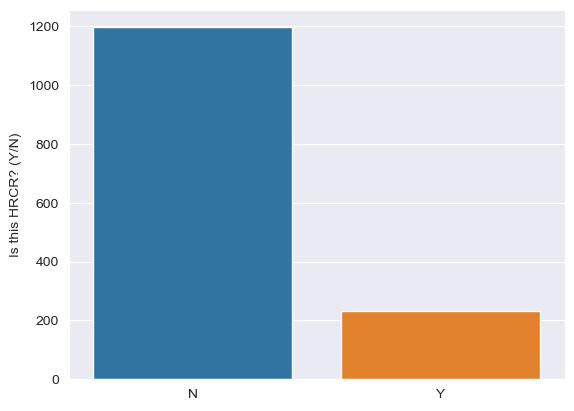

In [27]:
# Inspect target balance

data = df['Is this HRCR? (Y/N)'].value_counts()
print(data)
sns.barplot(data=data.reset_index() , x=data.index, y='Is this HRCR? (Y/N)')


<AxesSubplot: xlabel='lemma_count', ylabel='Density'>

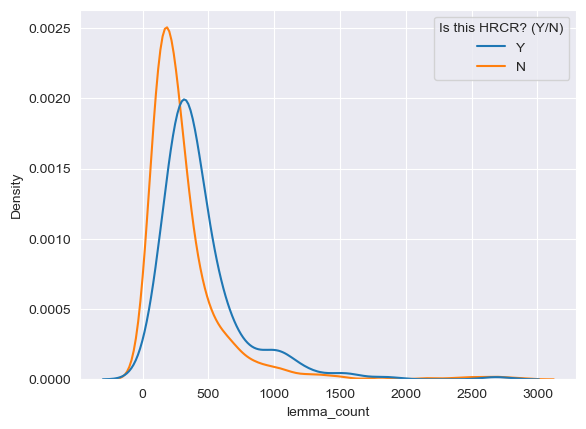

In [28]:
# visualize difference in length between targets

df['lemma_count'] = df['key_lemmas'].apply(lambda row: len(row))
sns.kdeplot(data=df, x='lemma_count', hue='Is this HRCR? (Y/N)', common_norm=False)


In [29]:
# create corpus of related phrases that would not get picked up by tfidf

related_phrases = [
    'community impact',
    'community health',
    'impact assessment',
    'community relation',
    'community stakeholder',
    'corporate responsibility',
    'social responsibility',
    'community input',
    'community outreach',
    'public comment',
    'human right',
    'local communit',
    'local population',
    'surrounding communit',
    'with local business',
    'with local farm',
    'first nation',
    'first-nation',
    'indigenous',
    'minority-owned',
    'tribal',
    'relief organi',
    'create  jobs',
    'social good',
    'social welfare',
    'social harm',
    'social impact',
    'social concern',
    'philanthro',
    'donat',
    'crowdfund',
    'volunteer',
    'social change',
    'raise awareness',
    'nonprofit',
    'non-profit',
    'trade union',
    'walkout',
    'strike',
    'affected workers',
    'pay compensation',
    'groundwater',
    'water quality',
    'safe water',
    'environmental risk',

]

# count number of related phrases that appear in articles

def count_list_items_in_string(lst, string):
    count_dict = {}
    for item in lst:
        count_dict[item] = string.count(item)
    return sum(count_dict.values())


# create feature of related phrases count

df['related_phrases'] = df.textbody_stripped.apply(lambda row: count_list_items_in_string(related_phrases, row))
df['token_number'] = df.key_lemmas.apply(lambda row: len(row))
df['related_phrases_prop'] = df.related_phrases / df.token_number


# job creation seems to be important, look for examples of jobs being created in articles

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

pattern = [ {"LEMMA": "create"}, {"POS": "ADJ", "OP" : "*"}, {"POS": "ADV", "OP" : "*"}, {"POS": "NUM", "OP" : "*"}, {"POS": "ADJ", "OP" : "*"}, {"TEXT": "jobs"}]
matcher.add("job_creator", [pattern])

df['job_creator'] = df['NLP'].apply(lambda row: len(matcher(row)))

# inspect job_creator. it may not be as useful as we thought. We will leave this out of the final model
df[df['job_creator'] > 0]

,Article ID,Is this HRCR? (Y/N),Sentiment,textbody,textbody_stripped,NLP,key_lemmas,lemma_count,related_phrases,token_number,related_phrases_prop,job_creator
17,ACQIND0020220311ei3a0002x,N,None,Reuters - U.S. EPA proposing rules to cut emis...,reuters - u.s. epa proposing rules to cut emis...,"(reuters, -, u.s, ., epa, proposing, rules, to...","[reuters, epa, proposing, rule, cut, emission,...",2878,0,2878,0.000000,1
32,AFBZ000020170505e861000r4,Y,Positive,A key objective is to enable Gabon to diversif...,a key objective is to enable gabon to diversif...,"(a, key, objective, is, to, enable, gabon, to,...","[key, objective, enable, gabon, diversify, eco...",1538,9,1538,0.005852,1
269,AUTN000020191212efc900003,Y,Neutral,By building one of the world's largest battery...,by building one of the worlds largest battery ...,"(by, building, one, of, the, worlds, largest, ...","[build, world, large, battery, plant, employ, ...",386,0,386,0.000000,1
310,BFL0000020220502ei520002t,Y,Positive,"The GEA Way Forward Goals\n\n* Create 10,000 U...","the gea way forward goals create 10,000 u.s....","(the, gea, way, forward, goals, , create, 10...","[gea, way, forward, goal, create, job, reach, ...",259,6,259,0.023166,1
346,BLMD000020210927e92e0096a,Y,Positive,"The $300,000 donation will fund The Choice Foo...","the 300,000 donation will fund the choice food...","(the, 300,000, donation, will, fund, the, choi...","[donation, fund, choice, food, pantry, kroc, c...",381,5,381,0.013123,1
354,BLMD000020210928ebbi001p8,Y,Positive,This unprecedented agreement calls for joint i...,this unprecedented agreement calls for joint i...,"(this, unprecedented, agreement, calls, for, j...","[unprecedented, agreement, call, joint, interv...",548,2,548,0.003650,2
355,BLMD000020210928ebc200237,Y,Positive,The United Nations Climate Change Conference i...,the united nations climate change conference i...,"(the, united, nations, climate, change, confer...","[united, nations, climate, change, conference,...",725,2,725,0.002759,1
417,BUSVE00020220429ei4t0015p,Y,Positive,The German-multinational energy giant is a tru...,the german-multinational energy giant is a tru...,"(the, german, -, multinational, energy, giant,...","[german, multinational, energy, giant, trust, ...",358,1,358,0.002793,1
512,CPR0000020140602ea61000a7,Y,Negative,"The 10-year plan, a pillar of the Progressive ...","the 10-year plan, a pillar of the progressive ...","(the, 10, -, year, plan, ,, a, pillar, of, the...","[year, plan, pillar, progressive, conservative...",384,1,384,0.002604,1
549,CWNS000020210511eh5b004y6,N,None,"""Everyone knows it takes more labor hours to a...",everyone knows it takes more labor hours to as...,"(everyone, knows, it, takes, more, labor, hour...","[know, take, labor, hour, assemble, build, com...",125,0,125,0.000000,1


<AxesSubplot: xlabel='related_phrases', ylabel='Proportion'>

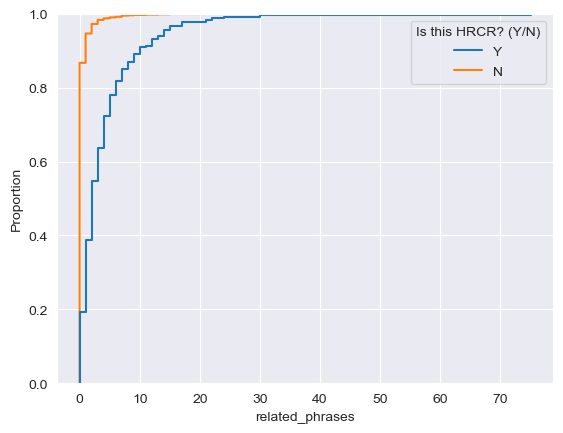

In [30]:
# visualize how many related phrases are in an article in each target class

sns.ecdfplot(data=df, x='related_phrases', hue='Is this HRCR? (Y/N)')

<AxesSubplot: xlabel='Is this HRCR? (Y/N)', ylabel='related_phrases'>

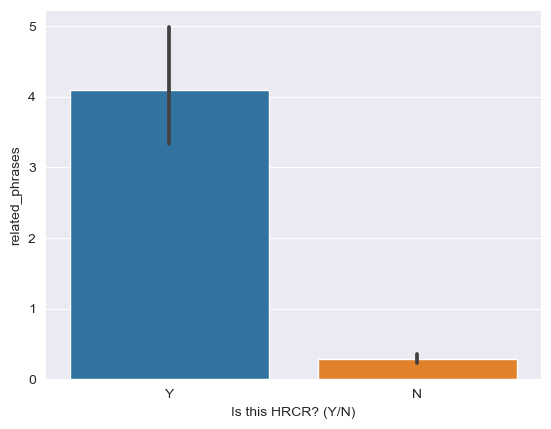

In [31]:
# visualize related phrases by relevance

sns.barplot(data=df, x='Is this HRCR? (Y/N)', y='related_phrases')

In [32]:
df

,Article ID,Is this HRCR? (Y/N),Sentiment,textbody,textbody_stripped,NLP,key_lemmas,lemma_count,related_phrases,token_number,related_phrases_prop,job_creator
0,ABBNWS0020211116ehbg000jm,Y,Positive,"""The proposed legislation will establish a too...",the proposed legislation will establish a tool...,"(the, proposed, legislation, will, establish, ...","[propose, legislation, establish, tool, enable...",217,4,217,0.018433,0
1,ABCGA00020220825ei8o0001j,N,None,"""Mr. Zatko's allegations of widespread securit...",mr. zatkos allegations of widespread security ...,"(mr, ., zatkos, allegations, of, widespread, s...","[mr, zatkos, allegation, widespread, security,...",170,0,170,0.000000,0
2,ABCNEW0020150216eb2g0000i,Y,Negative,The ground-breaking case has been in and out o...,the ground-breaking case has been in and out o...,"(the, ground, -, breaking, case, has, been, in...","[ground, break, case, court, year, appearance,...",577,2,577,0.003466,0
3,ABCNEW0020201218egci0002z,N,None,"The contaminant caused over $70,000 in damages...","the contaminant caused over 70,000 in damages ...","(the, contaminant, caused, over, 70,000, in, d...","[contaminant, cause, damage, home, car, coasta...",182,0,182,0.000000,0
4,ABCNEW0020210204eh230002x,N,None,But there has been slow progress to fix the sc...,but there has been slow progress to fix the sc...,"(but, there, has, been, slow, progress, to, fi...","[slow, progress, fix, scandal, expose, afterma...",1068,1,1068,0.000936,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2179,XNAP000020191201efbt00008,N,None,The move comes on the heels of an earlier laws...,the move comes on the heels of an earlier laws...,"(the, move, comes, on, the, heels, of, an, ear...","[come, heel, early, lawsuit, file, march, cons...",247,0,247,0.000000,0
2180,XNEWS00020191107efb700koh,N,None,The Paris court upheld charges of endangering...,the paris court upheld charges of endangering...,"( , the, paris, court, upheld, charges, of, en...","[paris, court, uphold, charge, endanger, peopl...",90,0,90,0.000000,0
2181,XWTH000020171114edbe0000j,N,None,The allegations involve the Lehigh Cement Co. ...,the allegations involve the lehigh cement co. ...,"(the, allegations, involve, the, lehigh, cemen...","[allegation, involve, lehigh, cement, plant, h...",248,4,248,0.016129,0
2182,YEDNO00020220919ei9j0008f,N,None,"According to the Dutch company’s statement, a ...","according to the dutch companys statement, a t...","(according, to, the, dutch, companys, statemen...","[accord, dutch, companys, statement, text, app...",71,2,71,0.028169,0


In [33]:

# transform the data into a format that can be fed into model
# leave out features that do not improve model performance

def transform_data(data, n_features, target, related=False):
    '''
    change key lemma tokens into one string to be fed into tfidf.
    combine related phrases and tfidf matrix into one featureset
    set target variable

    split data into train and test sets
    use ColumnTransformer to scale related phrases column while leaving tfidf alone
    fit transformer to training set, and apply it to training set and test set

    :param data:
    :param n_features:
    :param target:
    :param related:
    :return: training and testing features and targets
    '''

    data['bag_of_words'] = data.key_lemmas.apply(lambda row: ' '.join(row))
    bow = np.array(data.loc[:,'bag_of_words'].values)
    tfidf = TfidfVectorizer(lowercase=False, max_features=n_features)
    X_bow = tfidf.fit_transform(bow).toarray()
    if related:

        X_related = data[['related_phrases']].values
        X = np.hstack((X_bow, X_related))

    else:
        X = X_bow

    data['target'] = np.where(data['Is this HRCR? (Y/N)'] == 'Y', 1, 0)
    y = data[target].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state=100, stratify=y)
    ct = ColumnTransformer([('scaler', StandardScaler(), [-1])], remainder='passthrough')

    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    return X_train, X_test, y_train, y_test



In [34]:
# ensure again that there is no missing data

df.isna().sum()

Article ID              0
Is this HRCR? (Y/N)     0
Sentiment               0
textbody                0
textbody_stripped       0
NLP                     0
key_lemmas              0
lemma_count             0
related_phrases         0
token_number            0
related_phrases_prop    0
job_creator             0
dtype: int64

In [35]:

# get training and testing features using above function
X_train, X_test, y_train, y_test = transform_data(df, 500, 'target', related=True)

# define a dictionary to place model metrics into

algo_df = {'name':[],
           'balanced_accuracy':[],
           'f1_macro':[],
           'recall':[],
           'precision':[],
           'roc_auc':[]
}

# create a function to compare different base algorithms and their respective metrics with
def compare_algos(name, clf):

    cv = cross_validate(clf, X_train, y_train, cv=5, scoring=['balanced_accuracy','f1_macro','recall','precision','roc_auc'])
    algo_df['name'].append(name)
    algo_df['roc_auc'].append(cv['test_roc_auc'].mean())
    algo_df['balanced_accuracy'].append(cv['test_balanced_accuracy'].mean())
    algo_df['f1_macro'].append(cv['test_f1_macro'].mean())
    algo_df['recall'].append(cv['test_recall'].mean())
    algo_df['precision'].append(cv['test_precision'].mean())

# run function
compare_algos('Random Forest', RandomForestClassifier(class_weight='balanced', max_features='sqrt'))
compare_algos('Naive Bayes', GaussianNB())
compare_algos('SVM', LogisticRegression(class_weight='balanced'))
compare_algos('Logistic Regression', SVC(class_weight='balanced'))
compare_algos('Linear SVC', LinearSVC(class_weight='balanced'))



In [36]:
# place the model results in a dataframe and compare

algo_df = pd.DataFrame(algo_df)
algo_df.sort_values('balanced_accuracy', ascending=False)

,name,balanced_accuracy,f1_macro,recall,precision,roc_auc
3,Logistic Regression,0.873313,0.847926,0.815909,0.695763,0.924509
2,SVM,0.870601,0.847718,0.809280,0.698799,0.930808
4,Linear SVC,0.805568,0.795250,0.686364,0.649584,0.905226
1,Naive Bayes,0.788536,0.742630,0.716856,0.499162,0.849739
0,Random Forest,0.617755,0.649324,0.241477,0.893929,0.917470


In [37]:

# choose Logistic Regression based on the above performance (close with SVM but slight edge given for higher recall)
# initialize parameters to optimize hyperparameters
params = {'C': [0.1,1,2,4,8], 'penalty':['l2','l1','elasticnet'], 'l1_ratio':[0.25, 0.5, 0.75]}
clf = LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, n_jobs=-1, verbose=False)

# search through parameter grid and fit data with these parameters
grid = GridSearchCV(clf, cv=5, param_grid=params, refit=True, scoring='roc_auc')
grid.fit(X_train, y_train)

# save predictions and print results
y_pred = grid.predict(X_test)

print('Best score:', grid.best_score_)
print('Best parameters set:', grid.best_estimator_)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.

Best score: 0.9307711079464447
Best parameters set: LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.5, max_iter=1000,
                   n_jobs=-1, solver='saga', verbose=False)
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       359
           1       0.75      0.84      0.79        70

    accuracy                           0.93       429
   macro avg       0.86      0.89      0.87       429
weighted avg       0.93      0.93      0.93       429



array([[339,  20],
       [ 11,  59]])

In [38]:
# initialize VADER's sentiment analysis function
sentiment = SentimentIntensityAnalyzer()

# define a function to classify the sentiment of each row based on the polarity of the text with VADER
def sent_result_vader(doc):

    sent = sentiment.polarity_scores(doc)
    if sent['compound'] >= 0.05 :
        return 'Positive'

    elif sent['compound'] <= - 0.05 :
        return 'Negative'

    else :
        return 'Neutral'

# define a function to classify the sentiment of each row based on the polarity of the text with TextBlob

def sent_result_textblob(doc):

    sent = TextBlob(doc)
    if sent.sentiment.subjectivity > 0.05:

        if sent.sentiment.polarity >= 0.05 :
            return 'Positive'

        elif sent.sentiment.polarity <= - 0.05 :
            return 'Negative'

        else :
            return 'Neutral'

    else:
        return 'Neutral'

# subset the original dataframe to only include rows with labelled Sentiment

df_sent = df[df['Sentiment'] != 'None']

# Fix the typo in the labeling
df_sent['Sentiment'] = np.where(df_sent['Sentiment'] == 'Negaitve', 'Negative', df_sent['Sentiment'])

# Apply the above pre-trained functions to the dataset

df_sent['sent_analysis_vader'] = df_sent['textbody_stripped'].apply(lambda row: sent_result_vader(row))
df_sent['sent_analysis_score_vader'] = df_sent['textbody_stripped'].apply(lambda row: sentiment.polarity_scores(row)['compound'])
df_sent['sent_analysis_textblob'] = df_sent['textbody_stripped'].apply(lambda row: sent_result_textblob(row))

/var/folders/3p/bkhpj5cj7p77ghh4hx0hz_cw0000gn/T/ipykernel_37938/639206673.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['Sentiment'] = np.where(df_sent['Sentiment'] == 'Negaitve', 'Negative', df_sent['Sentiment'])
/var/folders/3p/bkhpj5cj7p77ghh4hx0hz_cw0000gn/T/ipykernel_37938/639206673.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['sent_analysis_vader'] = df_sent['textbody_stripped'].apply(lambda row: sent_result_vader(row))
/var/folders/3p/bkhpj5cj7p77ghh4hx0hz_cw0000gn/T/i

Sentiment
Positive    131
Negative     83
Neutral      18
dtype: int64


<AxesSubplot: xlabel='Sentiment', ylabel='count'>

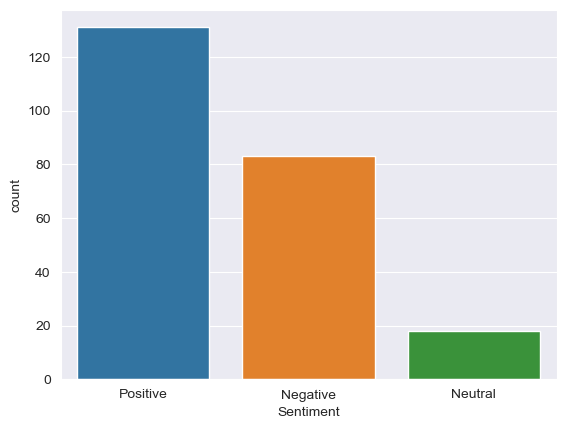

In [39]:
# visualize the distribution of Sentiments

print(df_sent.value_counts('Sentiment'))

sns.countplot(data=df_sent, x='Sentiment')

In [40]:
# View accuracy of textblob
(df_sent['Sentiment'] == df_sent['sent_analysis_textblob']).value_counts('data')

True     0.534483
False    0.465517
dtype: float64

In [41]:
# View accuracy of textblob
(df_sent['Sentiment'] == df_sent['sent_analysis_vader']).value_counts('data')

True     0.724138
False    0.275862
dtype: float64

In [42]:
df_sent

,Article ID,Is this HRCR? (Y/N),Sentiment,textbody,textbody_stripped,NLP,key_lemmas,lemma_count,related_phrases,token_number,related_phrases_prop,job_creator,bag_of_words,target,sent_analysis_vader,sent_analysis_score_vader,sent_analysis_textblob
0,ABBNWS0020211116ehbg000jm,Y,Positive,"""The proposed legislation will establish a too...",the proposed legislation will establish a tool...,"(the, proposed, legislation, will, establish, ...","[propose, legislation, establish, tool, enable...",217,4,217,0.018433,0,propose legislation establish tool enable gove...,1,Positive,0.9656,Positive
2,ABCNEW0020150216eb2g0000i,Y,Negative,The ground-breaking case has been in and out o...,the ground-breaking case has been in and out o...,"(the, ground, -, breaking, case, has, been, in...","[ground, break, case, court, year, appearance,...",577,2,577,0.003466,0,ground break case court year appearance soon l...,1,Positive,0.9989,Positive
6,ABCTRS0020070820e38k0002x,Y,Neutral,But Gunns needs to meet 24 conditions set down...,but gunns needs to meet 24 conditions set down...,"(but, gunns, needs, to, meet, 24, conditions, ...","[gunns, need, meet, condition, set, federal, e...",267,1,267,0.003745,0,gunns need meet condition set federal environm...,1,Negative,-0.1467,Positive
11,ABPTEL0020220919ei9k0009f,Y,Negative,The two injured miners were also admitted. Doc...,the two injured miners were also admitted. doc...,"(the, two, injured, miners, were, also, admitt...","[injure, miner, admit, doctor, say, suffer, se...",134,1,134,0.007463,0,injure miner admit doctor say suffer severe he...,1,Negative,-0.9869,Negative
25,ACWIRE0020221110eiba000ul,Y,Positive,* Appointed Arndt Brettschneider to the Board ...,appointed arndt brettschneider to the board o...,"( , appointed, arndt, brettschneider, to, the,...","[appoint, arndt, brettschneider, board, direct...",980,1,980,0.001020,0,appoint arndt brettschneider board director no...,1,Positive,0.8156,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,WSTA000020211027ehal0001q,Y,Positive,The ESG report is a comprehensive overview of ...,the esg report is a comprehensive overview of ...,"(the, esg, report, is, a, comprehensive, overv...","[esg, report, comprehensive, overview, metric,...",265,4,265,0.015094,0,esg report comprehensive overview metric polic...,1,Positive,0.9968,Positive
2173,WWD0000020210121eh1l0002x,Y,Positive,“It’s important to empower young adults and th...,its important to empower young adults and that...,"(its, important, to, empower, young, adults, a...","[important, empower, young, adult, include, wo...",322,2,322,0.006211,0,important empower young adult include woman am...,1,Positive,0.9978,Positive
2175,WWD0000020220422ei4m000mc,Y,Positive,There will also be a restaurant and a café wit...,there will also be a restaurant and a café wit...,"(there, will, also, be, a, restaurant, and, a,...","[restaurant, café, nation, cuisine, atrium, br...",569,17,569,0.029877,0,restaurant café nation cuisine atrium brighten...,1,Positive,0.9954,Positive
2176,XFOT000020200620eg6k0000h,Y,Negative,"The company could be fined up to $15,000 per d...","the company could be fined up to 15,000 per da...","(the, company, could, be, fined, up, to, 15,00...","[company, fine, day, violation, letter, say, t...",326,2,326,0.006135,0,company fine day violation letter say tolerate...,1,Negative,-0.9209,Neutral


In [45]:

# create a bag of words string for Count Vectorizer
df_sent['bag_of_words'] = df_sent.key_lemmas.apply(lambda row: ' '.join(row))

cv = CountVectorizer(lowercase=False, ngram_range = (1,2), max_features=1000)
X = cv.fit_transform(df_sent['bag_of_words'])

# remap sentiment to take values 0 for Negative, 1 for Neutral, and 2 for Positive and make target variable
df_sent['sent_val'] = np.where(df_sent['Sentiment'] == 'Positive', 2, np.where(df_sent['Sentiment'] == 'Negative', 0, 1))
y = df_sent['sent_val'].values

# split into train and test
X_sent_train, X_sent_test, y_sent_train, y_sent_test = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)


# create a dataframe to compare base algorithms' performance
algo_df_sent = {'name':[],
           'balanced_accuracy':[],
           'accuracy':[],
           'roc_auc_ovr':[]
           }
# create function to append algorithm results to dataframe
def compare_algos_sent(name, clf):

    cv = cross_validate(clf, X_sent_train, y_sent_train, cv=3, scoring=['balanced_accuracy','roc_auc_ovr','accuracy'])
    algo_df_sent['name'].append(name)
    algo_df_sent['roc_auc_ovr'].append(cv['test_roc_auc_ovr'].mean())
    algo_df_sent['balanced_accuracy'].append(cv['test_balanced_accuracy'].mean())
    algo_df_sent['accuracy'].append(cv['test_accuracy'].mean())

compare_algos_sent('Random Forest', RandomForestClassifier(class_weight='balanced'))
compare_algos_sent('Naive Bayes', MultinomialNB())
compare_algos_sent('Logistic Regression', LogisticRegression(class_weight='balanced'))
compare_algos_sent('SVM', SVC(class_weight='balanced', probability=True))
compare_algos_sent('XGBoost', XGBClassifier())

# see which algo proved the most promising on the data
algo_df_sent = pd.DataFrame(algo_df_sent)
algo_df_sent.sort_values('balanced_accuracy', ascending=False)

/var/folders/3p/bkhpj5cj7p77ghh4hx0hz_cw0000gn/T/ipykernel_37938/3447062589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['bag_of_words'] = df_sent.key_lemmas.apply(lambda row: ' '.join(row))
/var/folders/3p/bkhpj5cj7p77ghh4hx0hz_cw0000gn/T/ipykernel_37938/3447062589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['sent_val'] = np.where(df_sent['Sentiment'] == 'Positive', 2, np.where(df_sent['Sentiment'] == 'Negative', 0, 1))
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/

,name,balanced_accuracy,accuracy,roc_auc_ovr
1,Naive Bayes,0.607181,0.833333,0.814826
2,Logistic Regression,0.576382,0.802469,0.764386
4,XGBoost,0.562422,0.796296,0.841995
3,SVM,0.557159,0.790123,0.777513
0,Random Forest,0.536182,0.777778,0.870248


In [46]:
# Select Random Forest model, as this has the highest roc_auc

# create a pipeline to transform the data
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier(class_weight='balanced')),
])

# create param grid to feed through model
params = {
    'vect__max_features': (500, 750, 1000, 1500, 2000),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__max_depth': (1, 5, 10, None),
    'clf__min_samples_leaf': (1, 2, 4),
    'clf__min_samples_split': (2, 5, 10),
    'clf__n_estimators': (10, 100, 200)
}

# redefine train/test split using same random state to keep same split as above
# doing this to be able to perform a grid search on the Count Vectorizer and the Random forest hyperparameters

X_sent_train, X_sent_test, y_sent_train, y_sent_test = train_test_split(df_sent['bag_of_words'], df_sent['sent_val'], train_size=0.7, random_state=0, stratify=df_sent['sent_val'])

# perform grid search, fit the model with the best parameters
grid = GridSearchCV(pipe, param_grid=params, cv=3, scoring='roc_auc_ovr', refit=True)
grid.fit(X_sent_train, y_sent_train)

# print out best parameters and estimator
print('Best score:', grid.best_score_)
print('Best parameters set:', grid.best_estimator_)

# save predictions
y_pred = grid.predict(X_sent_test)

/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bradyallardice/opt/miniconda3/envs/torch-nightly/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Conver

Best score: 0.90929346631276
Best parameters set: Pipeline(steps=[('vect',
                 CountVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200))])


In [47]:
confusion_matrix(y_sent_test, y_pred)

array([[20,  0,  5],
       [ 2,  0,  3],
       [ 2,  0, 38]])